In [13]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
#from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    data = data.copy()
    if(isinstance(filters, float)):
        filters = [(0,-1,filters)]
    from scipy.ndimage import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st and sig > 0.0):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data       
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import os
import warnings

# Replace [0] darken old blue #1f77b4 (For Tritanopia blue-green)
# Replace [2] lighten old green #2ca02c (For Deuteranopia red-green)
# Replace [3] darken old red #d62728 (For Deuteranopia red-green)q
colors = ['#1c6ca3', '#ff7f0e', '#2fac2f', '#cb2525', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "stand_p_e_l" : colors[4],
    "stand" : colors[1], # Orange
    "decision_tree" : colors[0],
    "neural_net" : colors[5],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "xg_boost_active" : colors[2],
    "vssm" : "magenta",

    ("stand_hs", False) : colors[4],
    ("stand", False) : colors[1], # Orange
    ("decision_tree", False) : colors[0],
    ("neural_net", False) : colors[5],
    ("random_forest", False) : colors[3],
    ("xg_boost", False) : colors[2],

    ("stand_hs", True) : colors[4],
    ("stand", True) : colors[1], # Orange
    ("decision_tree", True) : colors[0],
    ("neural_net", True) : colors[5],
    ("random_forest", True) : colors[3],
    ("xg_boost", True) : colors[2],
    
    "stand_p" : colors[8],
    "stand_p_e" : colors[6],
    
    "stand_p_e_l_active" : colors[4],
    "stand_p_l" : colors[4],
    "stand_p_e_l_SC" : colors[1],
    "stand_p_e_l_SC_active" : colors[1],
    
    "stand_p00_e_l" : colors[1],
    "stand_p05_e_l" : colors[2],
    "stand_p1_e_l" : colors[3],
    "stand_p5_e_l" : colors[9],
    "stand_p10_e_l" : colors[5],
    "stand_p25_e_l" : colors[6],
    "stand_p50_e_l" : colors[4],
    "stand_p100_e_l" : colors[8],
    
    "stand_p_e00_l" : colors[1],
    "stand_p_e05_l" : colors[2],
    "stand_p_e1_l" : colors[3],
    "stand_p_e5_l" : colors[4],
    "stand_p_e10_l" : colors[5],
    "stand_p_e25_l" : colors[6],
    "stand_p_e50_l" : colors[8],
    "stand_p_e100_l" : colors[9],
    
    "stand_p_e_l5" : colors[1],
    "stand_p_e_l10" : colors[5],
    "stand_p_e_l25" : colors[6],
    "stand_p_e_l50" : colors[8],
    "stand_p_e_l100" : colors[9],
    
    "stand_sl0" : colors[1],
    "stand_sl5" : colors[4],
    "stand_sl10" : colors[5],
    "stand_sl15" : colors[9],
    "stand_sl20" : colors[6],
    "stand_sl25" : colors[8],
    #"stand_sl30" : colors[8],
    #"stand_sl40" : colors[9],
    #"stand_sl50" : colors[4],
    
    "stand_dyn" : colors[1], # Orange
    "stand_max" : colors[8],
    "stand_near" : colors[4],
    "stand_w_slip" : colors[3],
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    ("decision_tree", False) : "Decision Tree",
    ("decision_tree", True) : "Decision Tree",
    
    "random_forest" : "Random Forest",
    ("random_forest", False) : "Random Forest",
    ("random_forest", True) : "Random Forest",
    
    "xg_boost" : "XGBoost",
    ("xg_boost", False) : "XGBoost",
    ("xg_boost", True) : "XGBoost",
    
    "stand" : "STAND",
    ("stand", False) : "STAND",
    ("stand", True) : "STAND",
    
    "stand_p_e_l" : "STAND (hier. shrink)",
    ("stand_hs", False) : "STAND (hier. shrink)",
    ("stand_hs", True) : "STAND (hier. shrink)",
    
    "neural_net" : "Neural Net",
    ("neural_net", False) : "Neural Net",
    ("neural_net", True) : "Neural Net",
}

cond_marker_props = {
    #"stand_p5_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 5}, #(0,5)},
    "stand"          : {"marker" : "^", "markersize" : 6, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    ("stand", False) : {"marker" : "^", "markersize" : 6, "markevery" : 5},
    ("stand", True) : {"marker" : "^", "markersize" : 6, "markevery" : 5},
    "stand_p_e_l"       : {"marker" : "+", "markersize" : 6, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    ("stand_hs", False) : {"marker" : "+", "markersize" : 6, "markevery" : 5},
    ("stand_hs", True) : {"marker" : "+", "markersize" : 6, "markevery" : 5},
    "random_forest"          : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    ("random_forest", False) : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    ("random_forest", True) : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    "decision_tree"          : {"linestyle" : "--"},
    ("decision_tree", False) : {"linestyle" : "--"},
    ("decision_tree", True) : {"linestyle" : "--"},
    "neural_net"          : {"linestyle" : "dashdot"},
    ("neural_net", False) : {"linestyle" : "dashdot"},
    ("neural_net", True) : {"linestyle" : "dashdot"},
    "vssm"          : {"linestyle" : ":"},
    
    "stand_p_e_l_active" : {"linestyle" : "--"},
    "stand_p_e_l_SC_active" : {"linestyle" : "--"},
    "xg_boost_active" : {"linestyle" : "--"},
    
    "stand_p00_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 10},
    "stand_p05_e_l" : {"linestyle" : "--"},
    "stand_p1_e_l" : {"linestyle" : "--"},
    "stand_p5_e_l" : {"linestyle" : "--"},
    "stand_p10_e_l" : {"linestyle" : "--"},
    "stand_p25_e_l" : {"linestyle" : "--"},
    "stand_p50_e_l" : {"marker" : "o", "markersize" : 6, "markevery" : 10},
}

def load_stat_sets(file_pattern):
    stat_sets_by_model = {}
    for file_name in glob(file_pattern):
        with open(file_name, 'rb') as f:
            stats_by_model = pickle.load(f)
            for model_name, stats in stats_by_model.items():
                if(model_name == "rand_forest"):
                    model_name = "random_forest"
                if(model_name == "xgboost"):
                    model_name = "xg_boost"
                stats_list = stat_sets_by_model.get(model_name, [])
                stats_list.append(stats)
                stat_sets_by_model[model_name] = stats_list
    return stat_sets_by_model

def aggregate_stat(stat_sets_by_model, stat_name, agg_fn = np.nanmean, filt=None):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        #print(stat_name, stats_list)
        stat_vals = [x[stat_name] for x in stats_list if stat_name in x]
        if(filt):
            filt_name, filt_fn = filt
            filt_vals = [x[filt_name] for x in stats_list if filt_name in x]
            #print(stat_vals)
            #print(filt_vals)
            stat_vals = [(x if filt_fn(f) else np.nan) for x,f in zip(stat_vals, filt_vals)]
        
        if(len(stat_vals) == 0):
            continue
            
        if(isinstance(stat_vals[0], np.ndarray)):
            max_len = max([len(x) for x in stat_vals])
            stat_vals = np.array([np.pad(x, ((0, max_len-len(x))), mode='constant', constant_values=np.nan) for x in stat_vals])
            stat_vals = np.stack(stat_vals)
            
        with warnings.catch_warnings():
            stat_vals = np.array(stat_vals)
            agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan
        
        #if(isinstance(agg, np.ndarray)):
        #    agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out

def aggregate_active_utility(stat_sets_by_model, stat_name, stat_max=1):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        vals = [x[stat_name] for x in stats_list if stat_name in x]
        
        
        active_name = model_name + "_active"
        #print(active_name, active_name in curve_by_model)
        if(active_name in stat_sets_by_model):
            active_stat_list = stat_sets_by_model[active_name]
            a_vals = [x[stat_name] for x in active_stat_list if stat_name in x]
        else:
            continue
            #curve_pairs[model_name] = (curve, curve_by_model[active_name])

        if(len(vals) == 0):
            continue
        #print(model_name)
        
        norm_vals = []
        for v,a in zip(vals, a_vals):
            v = np.array(v)
            a = np.array(a)
            with np.errstate(divide='ignore', invalid='ignore'):
                #print(a-v)
                den = (stat_max-np.min([a,v], axis=0))
                nv = np.where(np.abs(den) > 1e-6, (a-v) / den, 1.0)
                norm_vals.append(nv)
                #print("v:", v)
                #print("a:", a)
                #print("nv:", nv)
            
        with warnings.catch_warnings():
            agg = np.nanmean(np.array(norm_vals), axis=0)
        agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out
        
def plot_legend_title(ax, title):
    if(not ax):
        plt.grid()
        plt.title(title)
        plt.legend(fontsize=10)
        _ax = plt
    else:
        ax.grid()
        ax.set_title(title)
        _ax = ax
    return _ax

def plot_axes(ax, x_lim, y_lim, x_label, y_label):
    if(ax):
        print("AX", ax)
        if(x_lim): ax.set_xlim(*x_lim)
        if(y_lim): ax.set_ylim(*y_lim)
        if(x_label): ax.set_xlabel(x_label)
        if(y_label): ax.set_ylabel(y_label)
    else:
        if(x_lim): plt.xlim(*x_lim)
        if(y_lim): plt.ylim(*y_lim)
        if(x_label): plt.xlabel(x_label)
        if(y_label): plt.ylabel(y_label)

def do_save(save_name):
    if(save_name): 
        os.makedirs("sim_plots", exist_ok=True)
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        #plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
        
def plot_stat(curve_by_model, title=None, skip=[], y_lim=None, x_lim=(-2,102), h_line=None,
              y_label=None, x_label="Number of Examples", save_name=None, show_active=False,
              smooth=2.0, ax=None):
    
    if(not ax):
        plt.figure(figsize=(7,3.5))
    
    _ax = plot_legend_title(ax, title)
    
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        _ax.plot(np.arange(1,len(curve)+1), gauss(curve*100, smooth), color=color, 
                 label=label, **marker_props, linewidth=2)
    
    
    if(h_line is not None): _ax.hlines(h_line, *x_lim, linestyle='--', color="#999")
    plot_axes(ax, x_lim, y_lim, x_label, y_label)
    do_save(save_name)
    
        #plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    if(not ax): plt.show()

    
def print_stats(stat_sets_by_model, stat_name=None, title=None, big_better=True, index=None):
    title = title if title else stat_name
    
    print(f"{title}:")
    if(stat_name is not None):
        with warnings.catch_warnings():
            if(index is None):
                d = {name : np.nanmean(np.array([x[stat_name] for x in stats if stat_name in x]),axis=0) 
                     for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
            else:
                
                d = {name : np.nanmean(np.array([x[stat_name][index] for x in stats if stat_name in x]),axis=0) 
                     for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
    else:
        d = stat_sets_by_model
            
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (model_name, val) in enumerate(d.items()):
        #when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        print(f"  {model_name}: {pre}{val*100:.2f}%{post}")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [8]:
stat_sets_by_model = load_stat_sets("sim_saves/*")
stats_vssm = load_stat_sets("vssm/*")

print(stats_vssm)

stat_sets_by_model = {**stat_sets_by_model, **stats_vssm}

{'vssm': [{'model_name': 'vssm', 'accuracies': [0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305, 0.5305], 'accuracy': 0.5305, ('total_precision', (0.5, 0.52)): 1.0, ('precision', (0.5, 0.52)): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

/tmp/ipykernel_5654/1607340749.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


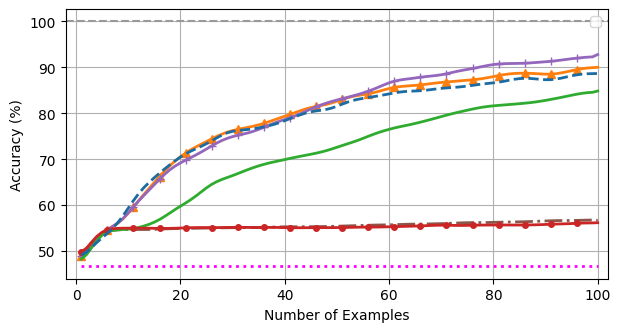

/tmp/ipykernel_5654/1607340749.py:200: RuntimeWarning: Mean of empty slice
  agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan
/tmp/ipykernel_5654/1607340749.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


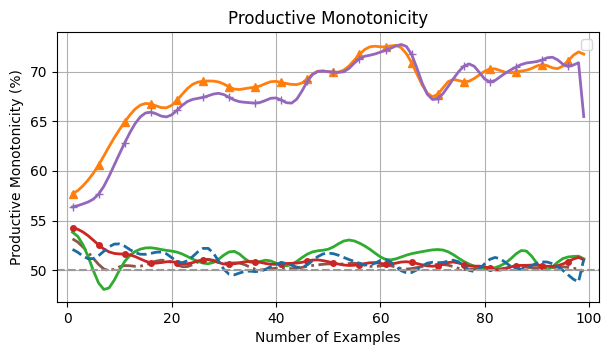

/tmp/ipykernel_5654/1607340749.py:200: RuntimeWarning: Mean of empty slice
  agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan
/tmp/ipykernel_5654/1607340749.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


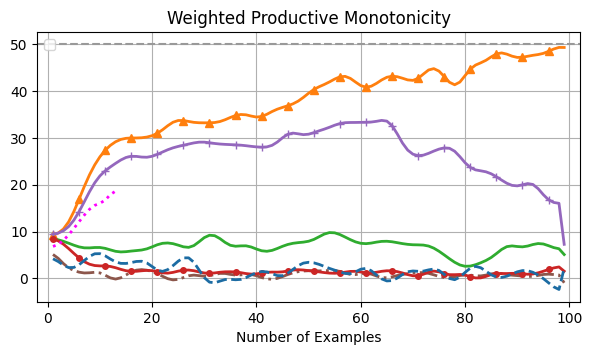

/tmp/ipykernel_5654/1607340749.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


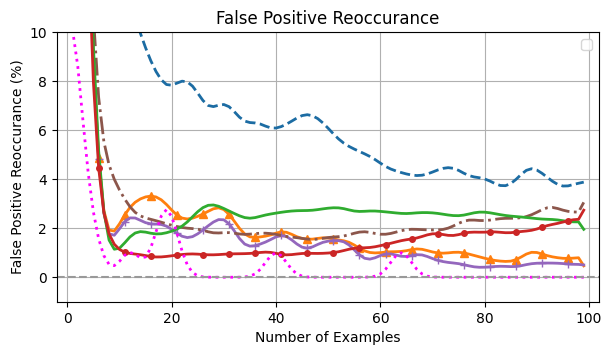

/tmp/ipykernel_5654/1607340749.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


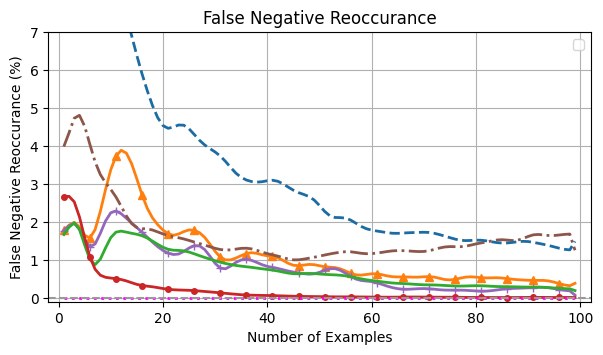

In [14]:
#stat_sets_by_model = load_stat_sets("sim_saves/*")

plot_stat( aggregate_stat(stat_sets_by_model, "accuracies"),
           None, h_line=100, show_active=False, y_label="Accuracy (%)", save_name="acc")
plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot")
plot_stat( aggregate_stat(stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,10), h_line=0, y_label="False Positive Reoccurance (%)", 
          save_name="fp_reoc")
plot_stat(aggregate_stat(stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,7), h_line=0, y_label="False Negative Reoccurance (%)",
          save_name="fn_reoc")

In [99]:
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=20", True, index=19)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=50", True, index=49)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=100", True, index=99)
print()
print_stats(stat_sets_by_model, "total_prod_monot", "Total Productive Monotonicity")
print_stats(stat_sets_by_model, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(stat_sets_by_model, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(stat_sets_by_model, "total_FP_reocc", "Total Omission Reoccurance", False)
print_stats(stat_sets_by_model, "avg_abs_prec_res", "Average Absolute Precision Residual", False)
print()

#stat_sets_w_o_dt = {k:v for k,v in stat_sets_by_model.items() if k != "decision_tree"}
#print_stats(stat_sets_w_o_dt, ("TN_n",(.50, .51)), "Total Precision @55% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.60, .7)), "Total Precision @65% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.70, .8)), "Total Precision @75% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.80, .9)), "Total Precision @85% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.90, .92)), "Total Precision @91% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.92, .94)), "Total Precision @93% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.94, .96)), "Total Precision @95% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.96, .98)), "Total Precision @96% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.98, 1.0)), "Total Precision @97% +/-1%", True)
print_stats(stat_sets_by_model, ("total_precision",(1.0, 1.0)), "Total Precision @100% +/-1%", True)


Total Productive Monotonicity:
  stand: 62.49%
  stand_active: 62.38%
  stand_p_e_l: 62.20%
  stand_p_e_l_active: 61.89%
  neural_net: 50.62%
  neural_net_active: 50.91%
  xg_boost: 53.61%
  xg_boost_active: 53.59%
  decision_tree: 52.61%
Total Error Reoccurance:
  stand: 1.82%
  stand_active: 2.09%
  stand_p_e_l: 1.54%
  stand_p_e_l_active: 2.12%
  neural_net: 2.39%
  neural_net_active: 1.90%
  xg_boost: 1.94%
  xg_boost_active: 1.66%
  decision_tree: 5.43%
Total Comission Reoccurance:
  stand: 1.16%
  stand_active: 1.42%
  stand_p_e_l: 0.93%
  stand_p_e_l_active: 1.46%
  neural_net: 1.68%
  neural_net_active: 1.26%
  xg_boost: 0.75%
  xg_boost_active: 0.65%
  decision_tree: 3.85%
Total Omission Reoccurance:
  stand: 2.61%
  stand_active: 2.88%
  stand_p_e_l: 2.29%
  stand_p_e_l_active: 2.90%
  neural_net: 3.27%
  neural_net_active: 2.70%
  xg_boost: 3.33%
  xg_boost_active: 2.83%
  decision_tree: 7.48%
Average Absolute Precision Residual:
  stand: 14.58%
  stand_active: 13.84%
  sta

[(0.5, 0.52), (0.52, 0.54), (0.54, 0.56), (0.56, 0.58), (0.58, 0.6), (0.6, 0.62), (0.62, 0.64), (0.64, 0.66), (0.66, 0.6799999999999999), (0.6799999999999999, 0.7), (0.7, 0.72), (0.72, 0.74), (0.74, 0.76), (0.76, 0.78), (0.78, 0.8), (0.8, 0.8200000000000001), (0.8200000000000001, 0.8400000000000001), (0.8400000000000001, 0.86), (0.86, 0.88), (0.88, 0.9), (0.9, 0.9199999999999999), (0.9199999999999999, 0.94), (0.94, 0.96), (0.96, 0.98), (0.98, 1.0), (1.0, 1.0)]


/tmp/ipykernel_5943/670296218.py:254: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


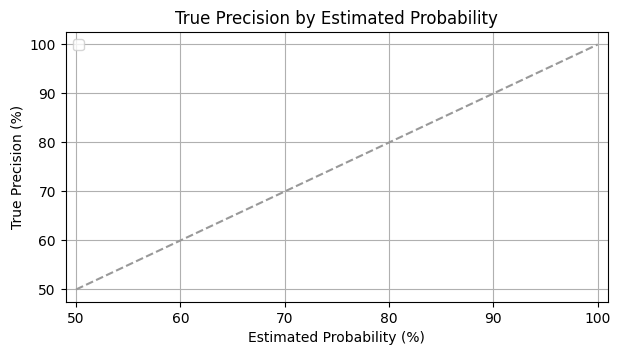

In [37]:

#DEFAULT_CERT_BINS = [( .5+(.01*(i)), .5+(.01*(i+1)) ) for i in range(50)]+[(1.0,1.0)]
DEFAULT_CERT_BINS = [( .5+(.02*(i)), .5+(.02*(i+1)) ) for i in range(25)]+[(1.0,1.0)]
#DEFAULT_CERT_BINS = [( .0+(.01*(i)), .0+(.01*(i+1)) ) for i in range(100)]+[(1.0,1.0)]
print(DEFAULT_CERT_BINS)

def plot_prec(bin_means, curve_by_model, title=None, skip=[], y_lim=None, x_lim=(49,101), h_line=None,
              line=None, smooth=0.0, ax=None,
              x_label="Estimated Probability (%)", y_label="True Precision (%)", save_name=None, show_active=False):
    
    if(not ax):
        plt.figure(figsize=(7,3.5))
    _ax = plot_legend_title(ax, title)
    
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        _ax.plot(bin_means*100, curve*100, color=color, 
                 label=label, **marker_props)
    
    if(line is not None): _ax.plot([x[0] for x in line], [x[1] for x in line], linestyle='--', color="#999")
    if(h_line is not None): _ax.hlines(h_line, *x_lim, linestyle='--', color="#999")

    
    plot_axes(ax, x_lim, y_lim, x_label, y_label)
    do_save(save_name)
    
    if(not ax): plt.show()

def plot_precision_curve(stat_sets_by_model,**kwargs):
    res_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    prec_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    bin_means = np.empty(len(DEFAULT_CERT_BINS))
    for i, cert_bin in enumerate(DEFAULT_CERT_BINS):
        c_min, c_max = cert_bin
        c_mean = (c_min + c_max) / 2
        c_hrng = (c_max - c_min) / 2
        #print(cert_bin)
        prec = aggregate_stat(stat_sets_by_model, ('total_precision', cert_bin), np.nanmean,
                              (('bin_n', cert_bin), lambda x: x >= 20))
        #TP_n = aggregate_stat(stat_sets_by_model, ('TP_n', cert_bin), np.sum, (()))
        #bin_n = aggregate_stat(stat_sets_by_model, ('bin_n', cert_bin), np.sum)
        #prec = {k:TP_n[k]/bin_n[k] for k in TP_n}    


        bin_means[i] = c_mean
        for k,p in prec.items():
            res_by_model[k][i] = p-c_mean
            prec_by_model[k][i] = p
    
#print(prec_by_model)

    plot_prec(bin_means, prec_by_model, line=[(50,50),(100,100)], **kwargs)

    
stat_sets_by_model = load_stat_sets("sim_saves/*")
stat_sets_pred_models = {k:v for k,v in stat_sets_by_model.items() if not any(x in k for x in ["VSSM", "decision_tree"])}

plot_precision_curve(stat_sets_pred_models,
                     title="True Precision by Estimated Probability", save_name='prec')
    #prec = stats[('total_precision', cert_bin)]
    #TP_n = stats[('TP_n', cert_bin)]
    #bin_n = stats[('bin_n', cert_bin)]

#plot_stat(aggregate_active_utility(stat_sets_by_model, "accuracies"),
#                  "Active Learning Utility", h_line=100)


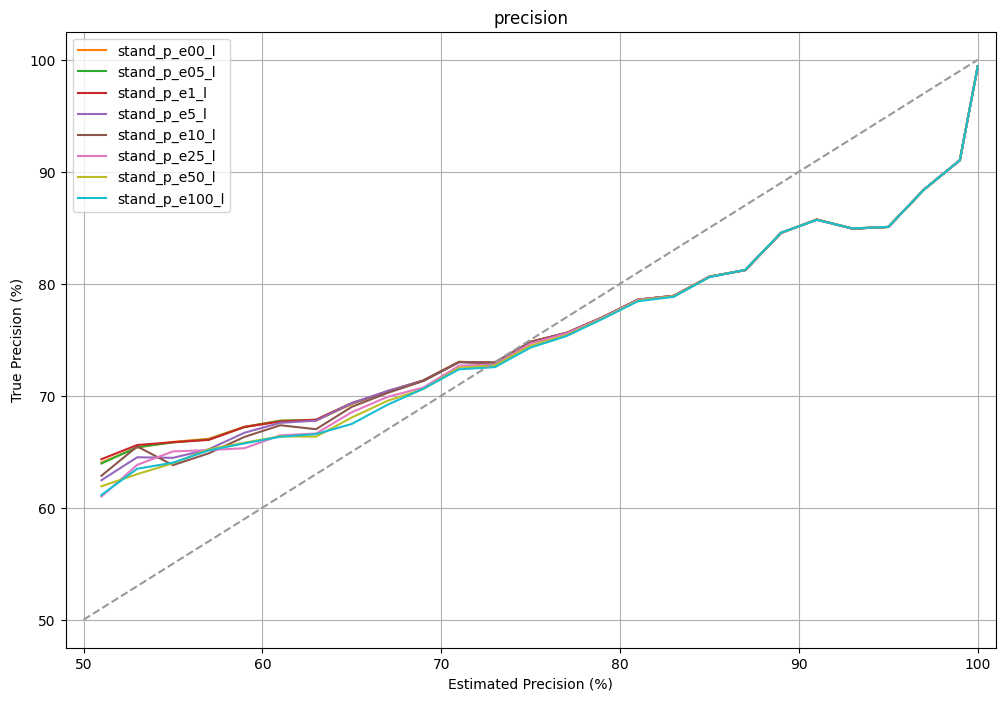

In [5]:
plot_precision_curve(load_stat_sets("e_hyper/*"))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

print(axes)


plot_stat( aggregate_stat(stat_sets_pred_models, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", ax=ax0)

plot_precision_curve(stat_sets_pred_models, ax=ax1,
                     title="True Precision by Estimated Probability")#, save_name='prec')

plot_stat(aggregate_active_utility(stat_sets_pred_models, "accuracies"), ax=ax2,
                  title="Normalized Active Learning Utility", y_label="Active Accuracy / (1-Accuracy) (%)", y_lim=(-10,40))#, save_name="act_lrn")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/monot_prec_alu.png", bbox_inches='tight')
plt.show()


#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax1)
#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax2)

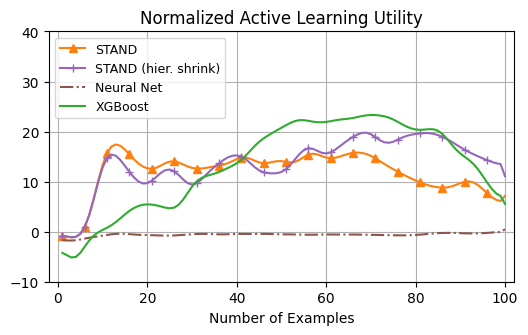

In [97]:
stat_sets_by_model = load_stat_sets("sim_saves/*")

#plot_active_diff( aggregate_stat(stat_sets_by_model, "accuracies"),
#                  "Active Learning Utility", h_line=100)
plot_stat(aggregate_active_utility(stat_sets_by_model, "accuracies"),
                  "Normalized Active Learning Utility", y_lim=(-10,40), save_name="act_lrn")

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from gen_synth_conds import gen_synthetic_dnf_data, print_dnf
from numpy.random import poisson
from numba import njit
import seaborn as sns

min_one_possion = lambda x : 1+poisson(x-1)
min_two_possion = lambda x : 2+poisson(x-2)


@njit(cache=True)
def categorical_corr(X):
    N, M = X.shape
    corr = np.zeros((X.shape[1], X.shape[1]), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            corr[i,j] = np.sum(X[:, i] == X[:, j]) / N
    return corr

def zero_true_lits(correlation_matrix, dnf):
    for conj in dnf:
        for lit in conj:
            ind = lit['ind']
            correlation_matrix[ind, ind] = 0.0
            
def plot_co_occurance_matrix(X,y, dnf):
    Xy = np.concatenate([X,y.reshape(-1,1)], axis=1)


    #correlation_matrix = np.corrcoef(X.T)

    co_occurance_matrix = categorical_corr(Xy)


            
    zero_true_lits(co_occurance_matrix, dnf)

    #print(co_occurance_matrix.shape)
    #import numpy as np
    #import matplotlib.pyplot as plt


    plt.figure(figsize=(20, 14))  # Adjust size as needed
    plt.imshow(X, cmap='viridis')
    # Add a colorbar
    #plt.colorbar()

    pallette = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(co_occurance_matrix, annot=False, cmap=pallette)#, fmt=".2f",
    #            xticklabels=[f"Var{i}" for i in range(X.shape[1])],
    #            yticklabels=[f"Var{i}" for i in range(X.shape[1])])
    plt.title("Correlation Matrix")
    plt.show()


    
X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=50,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.3,
                          conj_probs=.28,

                          neg_conj_len=lambda : min_two_possion(4),
                          num_neg_conj=100,
                          neg_dupl_lit_prob=0.3,
                          neg_conj_overlap=.3,

                          force_same_vals=False)
print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf)


print("=1 Prop", np.sum(y==1)/len(y), np.sum(y==1)/len(y))

X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=50,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.2,
                          conj_probs=.28,

                          #neg_conj_len=lambda : min_two_possion(3),
                          num_neg_conj=0,
                          #neg_dupl_lit_prob=0.1,
                          #neg_conj_probs=.8,

                          force_same_vals=False)

print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf)







ModuleNotFoundError: No module named 'seaborn'

In [32]:
from training import run_training, train_reps, train_or_load_condition

mc_conditions = {
    ("mc", "stand", True) : {"n_prob": 25, "reps" : 40},
    ("mc", "stand_hs", True) : {"n_prob": 25, "reps" : 40},
    ("mc", "decision_tree", True) : {"n_prob": 25, "reps" : 15},
    ("mc", "random_forest", True) : {"n_prob": 25, "reps" : 20},
    ("mc", "xg_boost", True) : {"n_prob": 25, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

mc_conditions_active = {
    ("mc", "stand", True, True) : {"n_prob": 25, "reps" : 40},
    ("mc", "stand_hs", True, True) : {"n_prob": 25, "reps" : 40},
    #("mc", "decision_tree", True, True) : {"n_prob": 25, "reps" : 15},
    ("mc", "random_forest", True, True) : {"n_prob": 25, "reps" : 10},
    ("mc", "xg_boost", True, True) : {"n_prob": 25, "reps" : 40},
    
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

#frac_conditions = {
#    ("frac", "stand", False) : {"n_prob": 100, "reps" : 40},
#    ("frac", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
#    ("frac", "random_forest", False) : {"n_prob": 100, "reps" : 40},
#    ("frac", "xg_boost", False) : {"n_prob": 100, "reps" : 40},
#}

frac_conditions = {
    ("frac", "stand", False) : {"n_prob": 25, "reps" : 30},
    ("frac", "stand_hs", False) : {"n_prob": 25, "reps" : 40},
    ("frac", "decision_tree", False) : {"n_prob": 25, "reps" : 40},
    ("frac", "random_forest", False) : {"n_prob": 25, "reps" : 30},
    ("frac", "xg_boost", False) : {"n_prob": 25, "reps" : 30},
}

frac_conditions_active = {
    ("frac", "stand", False, True) : {"n_prob": 25, "reps" : 40},
    ("frac", "stand_hs", False, True) : {"n_prob": 25, "reps" : 40},
    #("frac", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("frac", "random_forest", False, True) : {"n_prob": 25, "reps" : 5},
    ("frac", "xg_boost", False, True) : {"n_prob": 25, "reps" : 40},
}

stat_cache = {}
def stats_by_cond(conditions, stat_name=None, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_prob", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        if(stat_name):
            out[(tup[1], tup[2])] = ret[stat_name][kind]
        else:
            out[(tup[1], tup[2])] = ret
    return out

def stats_at_index_by_cond(conditions, grp, stat_name, index, kind="avg"):
    stats = stats_by_cond(conditions, grp, stat_name, kind)
    stats = {k:v[index] for k,v in stats.items()}
    return stats

def ai2t_plot_precision_curve(stat_sets_by_model,**kwargs):
    #print(list(stat_sets_by_model.keys()))
    res_by_model = {(k[1],k[2]):np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    prec_by_model = {(k[1],k[2]):np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    bin_means = np.empty(len(DEFAULT_CERT_BINS))
    for i, cert_bin in enumerate(DEFAULT_CERT_BINS):
        c_min, c_max = cert_bin
        c_mean = (c_min + c_max) / 2
        c_hrng = (c_max - c_min) / 2
        #print(cert_bin)
        
        prec = stats_by_cond(stat_sets_by_model, ('total_precision', cert_bin))
        TP_n = stats_by_cond(stat_sets_by_model, ('TP_n', cert_bin))

        #print(prec)
        
        #print(cert_bin, prec, TP_n)
        #prec = aggregate_stat(stat_sets_by_model, ('total_precision', cert_bin), np.nanmean,
        #                      (('bin_n', cert_bin), lambda x: x >= 20))
        #TP_n = aggregate_stat(stat_sets_by_model, ('TP_n', cert_bin), np.sum, (()))
        #bin_n = aggregate_stat(stat_sets_by_model, ('bin_n', cert_bin), np.sum)
        #prec = {k:TP_n[k]/bin_n[k] for k in TP_n}    


        bin_means[i] = c_mean
        for k,p in prec.items():
            if(TP_n[k] < 20):
                p = np.nan
            res_by_model[k][i] = p-c_mean
            prec_by_model[k][i] = p
    
#print(prec_by_model)

    plot_prec(bin_means, prec_by_model, line=[(50,50),(100,100)], **kwargs)


def ai2t_plot_diff(stats, stats_active, stat='accuracy', title=None, 
              x_lim=None, y_lim=None, h_line=None,
              y_label=None, x_label="Number of Problems", ax=None, save_name=None):

    title = title if title else stat
    plt.figure(figsize=(6,4))

    if(not ax):
        plt.figure(figsize=(7,3.5))
    _ax = plot_legend_title(ax, title)
    
    #print(list(conds_active.keys()))
    #print(list(conds.keys()))
    #conds = {(a,b,c):conditions[(a,b,c)] for (a,b,c,d) in conds_active}
    #stats = stats_by_cond(conds, stat)
    #stats_conds  = stats_by_cond(conds_active, stat)
    for cond, curve1 in stats_active.items():
        print(cond, curve1)
        curve0 = stats.get(cond, None)
        if(curve0 is None):
            continue
    #for (c0, curve0), (c1, curve1) in zip(stats.items(), stats_conds.items()):
     #   when, has_proc = c0
        curve0 = gauss(curve0)
        curve1 = gauss(curve1)
        diff = ((curve1-curve0)/(1-curve0))
        _ax.plot(np.arange(1,len(diff)+1), diff, color=cond_colors.get(cond, "grey"), 
                 label=cond_labels.get(cond, cond), **cond_marker_props.get(cond, {}))
    plt.grid()
    #plt.title(title)
    plt.legend()
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")

    plot_axes(ax, x_lim, y_lim, x_label, y_label)

    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()



('stand', False) [0.35282866 0.42650862 0.65999461 0.75258621 0.81915409 0.85064655
 0.8544181  0.85619612 0.85589978 0.85921336 0.86382004 0.86384698
 0.87928341 0.87922953 0.88054957 0.88305496 0.88456358 0.88588362
 0.8856681  0.88698815 0.88876616 0.88822737 0.88755388 0.88968211
 0.89100216]
('stand_hs', False) [0.40153556 0.48119612 0.64450431 0.75673491 0.83122306 0.86002155
 0.86821121 0.87128233 0.87098599 0.8673222  0.8717403  0.87122845
 0.89024784 0.89366918 0.89652478 0.89606681 0.89959591 0.89970366
 0.89959591 0.89884159 0.90048491 0.89932651 0.89884159 0.90064655
 0.90086207]
('random_forest', False) [0.41443966 0.41443966 0.42844828 0.60732759 0.74310345 0.76293103
 0.78340517 0.79073276 0.7887931  0.81293103 0.81918103 0.81508621
 0.82758621 0.82543103 0.82693966 0.82543103 0.82456897 0.83038793
 0.8362069  0.84159483 0.83534483 0.84008621 0.84030172 0.83857759
 0.83943966]
('xg_boost', False) [0.37710129 0.37710129 0.55223599 0.62007004 0.72882543 0.74862608
 0.79358

/tmp/ipykernel_5943/670296218.py:254: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


<Figure size 600x400 with 0 Axes>

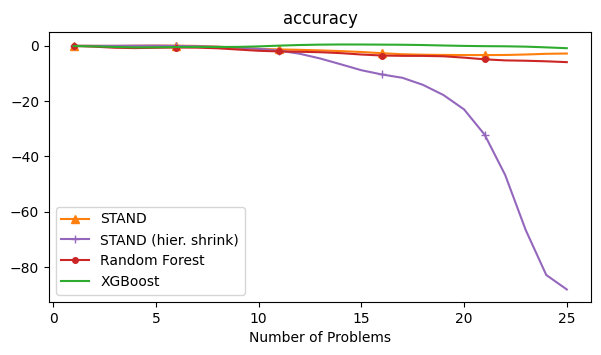

THIS HAPPNED
SKIP REP:  0
THIS HAPPNED
SKIP REP:  1
THIS HAPPNED
SKIP REP:  2
THIS HAPPNED
SKIP REP:  3
THIS HAPPNED
SKIP REP:  4
THIS HAPPNED
SKIP REP:  5
THIS HAPPNED
SKIP REP:  6
THIS HAPPNED
SKIP REP:  7
THIS HAPPNED
SKIP REP:  8
THIS HAPPNED
SKIP REP:  9


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



<Figure size 600x400 with 0 Axes>

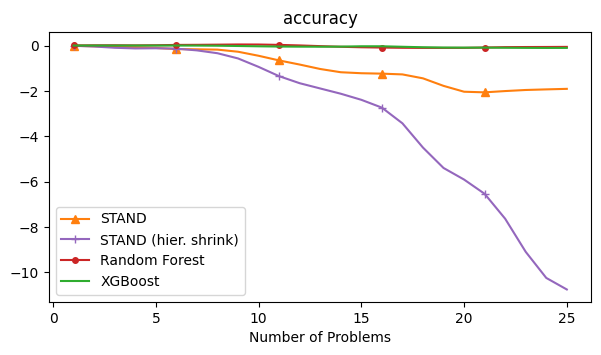

In [34]:
ai2t_plot_diff(stats_by_cond(frac_conditions, "completeness"), stats_by_cond(frac_conditions_active, "completeness"))
ai2t_plot_diff(stats_by_cond(mc_conditions, "completeness"), stats_by_cond(mc_conditions_active, "completeness"))

/tmp/ipykernel_6538/670296218.py:254: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


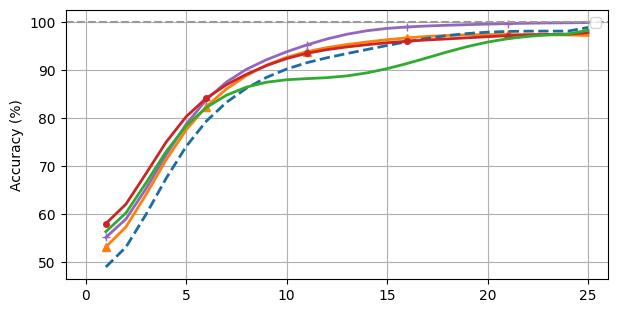

FP Reoccurance:
  ('stand', False): 1.16%
  ('stand_hs', False): 1.35%
  ('decision_tree', False): 0.20%
  ('random_forest', False): 2.33%
  ('xg_boost', False): 3.13%
FN Reoccurance:
  ('stand', False): 0.29%
  ('stand_hs', False): 0.27%
  ('decision_tree', False): 0.44%
  ('random_forest', False): 0.19%
  ('xg_boost', False): 1.10%


In [131]:
# Fractions
plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           None, x_lim = (-1,26), h_line=100, show_active=False,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")



print_stats(stats_by_cond(frac_conditions, "total_FP_reocc"), title="FP Reoccurance", big_better=False)
print_stats(stats_by_cond(frac_conditions, "total_FN_reocc"), title="FN Reoccurance", big_better=False)


#print_stats(stat_sets_by_model, "total_FP_reocc", "Total Omission Reoccurance", False)

[<Axes: > <Axes: > <Axes: >]
AX Axes(0.125,0.11;0.227941x0.77)
{('frac', 'stand', False): {'n_prob': 25, 'reps': 30}, ('frac', 'stand_hs', False): {'n_prob': 25, 'reps': 40}, ('frac', 'random_forest', False): {'n_prob': 25, 'reps': 30}, ('frac', 'xg_boost', False): {'n_prob': 25, 'reps': 30}}
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


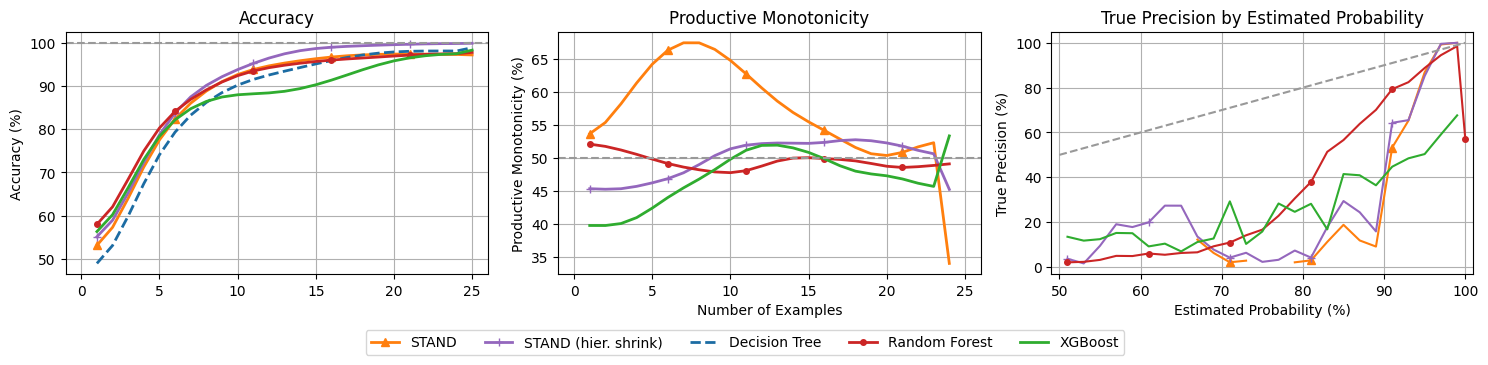

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

print(axes)

plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           "Accuracy", x_lim = (-1,26), h_line=100, show_active=False, ax=ax0,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")


frac_conditions_no_pred = {k:v for k,v in frac_conditions.items() if k[1] not in ['decision_tree']}

print(frac_conditions_no_pred)

plot_stat( stats_by_cond(frac_conditions_no_pred, "prod_monot"),
           title="Productive Monotonicity", x_lim = (-1,26), ax=ax1,
           h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot")

ai2t_plot_precision_curve(frac_conditions_no_pred, ax=ax2,
                     title="True Precision by Estimated Probability", save_name='prec')

#plot_stat(aggregate_active_utility(stat_sets_pred_models, "accuracies"), ax=ax2,
#                  title="Normalized Active Learning Utility", y_label="Active Accuracy / (1-Accuracy) (%)", y_lim=(-10,40))#, save_name="act_lrn")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/monot_prec_alu.png", bbox_inches='tight')
plt.show()


#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax1)
#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax2)

/tmp/ipykernel_5943/670296218.py:254: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


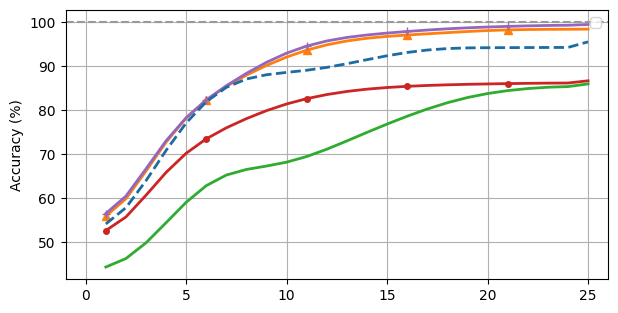

FP Reoccurance:
  ('stand', True): 0.55%
  ('stand_hs', True): 0.67%
  ('decision_tree', True): 0.28%
  ('random_forest', True): 3.20%
  ('xg_boost', True): 4.04%
FN Reoccurance:
  ('stand', True): 0.38%
  ('stand_hs', True): 0.49%
  ('decision_tree', True): 0.97%
  ('random_forest', True): 1.81%
  ('xg_boost', True): 3.85%


In [35]:
# Fractions
plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), h_line=100, show_active=False,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

print_stats(stats_by_cond(mc_conditions, "total_FP_reocc"), title="FP Reoccurance", big_better=False)
print_stats(stats_by_cond(mc_conditions, "total_FN_reocc"), title="FN Reoccurance", big_better=False)


[<Axes: > <Axes: > <Axes: >]
AX Axes(0.125,0.11;0.227941x0.77)
AX Axes(0.398529,0.11;0.227941x0.77)
AX Axes(0.672059,0.11;0.227941x0.77)


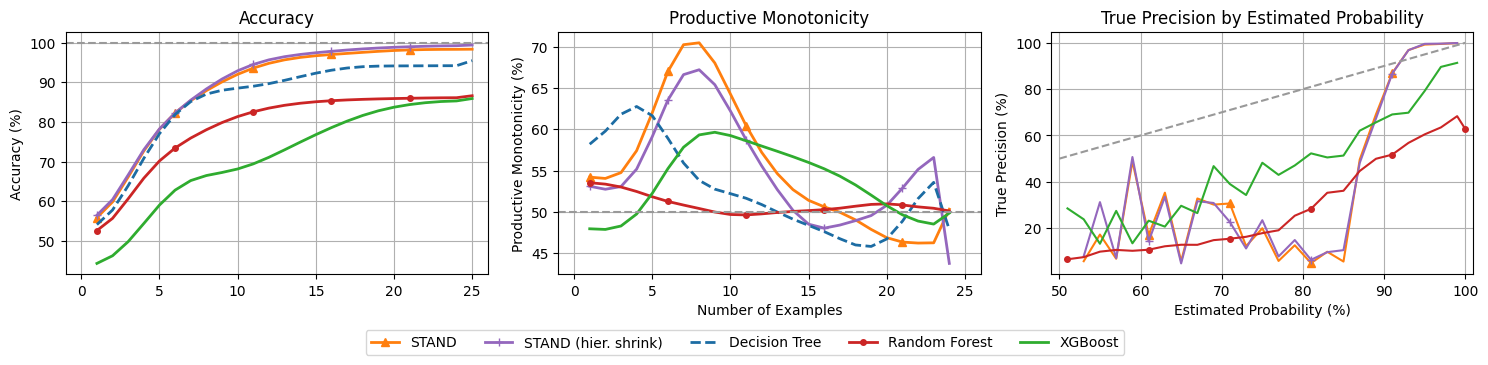

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=False, sharey=False)
ax0,ax1,ax2 = axes

print(axes)

plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           "Accuracy", x_lim = (-1,26), h_line=100, show_active=False, ax=ax0,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

plot_stat( stats_by_cond(mc_conditions, "prod_monot"),
           title="Productive Monotonicity", x_lim = (-1,26), ax=ax1,
           h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot")

ai2t_plot_precision_curve(mc_conditions, ax=ax2,
                     title="True Precision by Estimated Probability", save_name='prec')

#plot_stat(aggregate_active_utility(stat_sets_pred_models, "accuracies"), ax=ax2,
#                  title="Normalized Active Learning Utility", y_label="Active Accuracy / (1-Accuracy) (%)", y_lim=(-10,40))#, save_name="act_lrn")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(f"sim_plots/monot_prec_alu.png", bbox_inches='tight')
plt.show()


#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax1)
#plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
#           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot", ax=ax2)

AX Axes(0.125,0.385;0.348315x0.495)
AX Axes(0.551685,0.11;0.348315x0.22)
AX Axes(0.551685,0.385;0.348315x0.22)
AX Axes(0.551685,0.66;0.348315x0.22)


/tmp/ipykernel_5943/860425042.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


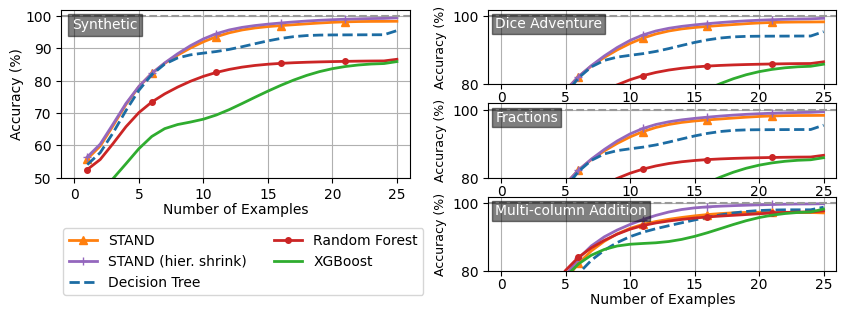

In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample images (you can replace these with your actual images)
large_image = np.random.rand(200, 300)
small_images = [np.random.rand(60, 200) for _ in range(3)]

# Create the figure
fig = plt.figure(figsize=(10, 3.4))
gs = gridspec.GridSpec(3, 2, width_ratios=[2, 2], height_ratios=[1, 1, 1], wspace=0.225, hspace=0.25)

# Left: Large image spans all 3 rows
ax_large = plt.subplot(gs[:-1, 0])
#ax_large.imshow(large_image, cmap='gray')
#ax_large.set_title('Large Image')
#ax_large.axis('off')

ax_large.text(0.03, 0.95, "Synthetic", color='white', fontsize=10,
            ha='left', va='top', transform=ax_large.transAxes,
            bbox=dict(facecolor='black', alpha=0.5, pad=3))
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', ncol=2, bbox_to_anchor=(0.12, 0.02))


#ax_large.set_xlabel("Number of Examples")


# Right: 3 smaller images
small_ax = []
small_text = ["Dice Adventure", "Fractions", "Multi-column Addition"]
for i in range(3):
    ax = plt.subplot(gs[i, 1])
    #ax.imshow(small_images[i], cmap='gray')
    #ax.set_title(f'Small Image {i+1}')
    #ax.axis('off')

    small_ax.append(ax)

    ax.text(0.02, 0.9, small_text[i], color='white', fontsize=10,
            ha='left', va='top', transform=ax.transAxes,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax_large.set_ylabel("Accuracy (%)", labelpad=1)

sax0, sax1, sax2 = small_ax

from matplotlib.patches import Patch
#legend_elements = [
#    Patch(facecolor='gray', label='Category A'),
#    Patch(facecolor='black', label='Category B'),
#    Patch(facecolor='gray', label='Category A'),
#    Patch(facecolor='black', label='Category B'),
#    Patch(facecolor='gray', label='Category A'),
#    Patch(facecolor='black', label='Category B')
#]

# Add legend under the large image
#ax_large.legend(handles=legend_elements,
#                loc='lower center',
#                bbox_to_anchor=(0.5, -0.7),  # Adjust vertical position
#                ncol=2,
#                frameon=False)

plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(50,102), h_line=100, show_active=False, ax=ax_large,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

plot_stat( stats_by_cond(frac_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,102), h_line=100, show_active=False, ax=sax2,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")


plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,102), h_line=100, show_active=False, ax=sax1,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")


plot_stat( stats_by_cond(mc_conditions, "completeness"), 
           None, x_lim = (-1,26), y_lim=(80,102), h_line=100, show_active=False, ax=sax0,
           x_label = "", y_label="Accuracy (%)")#, save_name="acc")

sax2.tick_params(axis="x", pad=1)
sax1.tick_params(axis="x", pad=1)
sax0.tick_params(axis="x", pad=1)

sax2.set_ylabel("Accuracy (%)", fontsize=9)
sax1.set_ylabel("Accuracy (%)", fontsize=9)
sax0.set_ylabel("Accuracy (%)", fontsize=9)

sax2.set_xlabel("Number of Examples",labelpad=1)
ax_large.set_xlabel("Number of Examples", labelpad=1)





plt.tight_layout()
plt.show()

In [ ]:
ph_stat_sets_by_model = load_stat_sets("p_hyper/*")

plot_stat( aggregate_stat(ph_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(ph_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(ph_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0, save_name="mc_oms")
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0, save_name="frac_oms")

In [ ]:
eh_stat_sets_by_model = load_stat_sets("e_hyper/*")

plot_stat( aggregate_stat(eh_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0, save_name="mc_oms")
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0, save_name="frac_oms")